# Train VAE for task2

This notebook trains a VAE model for task 2.

Loss function is as usual VAE: $loss = L_{KLD} + L_{Reconstruction}$

In [1]:
# public modules
from dlcliche.notebook import *
from dlcliche.utils import (
    sys, random, Path, np, plt, EasyDict,
    ensure_folder, deterministic_everything,
)
from argparse import Namespace

# private modules
sys.path.append('..')
import common as com

from pytorch_common import *
from model import VAE, VAE_loss_function

# loading parameters -> hparams (argparse compatible)
params = EasyDict(com.yaml_load('config.yaml'))

# create working directory
ensure_folder(params.model_directory)

# test directories
dirs = com.select_dirs(param=params, mode='development')

# fix random seeds
deterministic_everything(2020, pytorch=True)

# PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2020-03-16 10:17:47,412 - INFO - load_directory <- development


In [2]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6007 (pid 28384), started 1 day, 16:28:12 ago. (Use '!kill 28384' to kill it.)

In [3]:
# VAE Training class

class Task2VAELightning(Task2Lightning):

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat, z, mu, logvar = self.model.forward_all(x)
        loss = VAE_loss_function(recon_x=y_hat, x=x, mu=mu, logvar=logvar,
                                 reconst_loss='mse',
                                 a_RECONST=1.,
                                 a_KLD=1.)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}


# train models

for target_dir in dirs:
    target = str(target_dir).split('/')[-1]
    print(f'==== Start training [{target}] with {torch.cuda.device_count()} GPU(s). ====')

    files = com.file_list_generator(target_dir)

    model = VAE(device, x_dim=params.VAE.x_dim, h_dim=params.VAE.h_dim, z_dim=params.VAE.z_dim).to(device)
    if target == 'ToyCar': summary(device, model)
    task2 = Task2VAELightning(device, model, params, files, normalize=True)
    trainer = pl.Trainer(max_epochs=10, # params.fit.epochs,  ###### Simple try --> short epochs
                         gpus=torch.cuda.device_count())
    trainer.fit(task2)
    
    model_file = f'{params.model_directory}/model_{target}.pth'
    torch.save(task2.model.state_dict(), model_file)
    print(f'saved {model_file}.\n')

2020-03-16 10:17:47,457 - INFO - target_dir : dev_data/ToyConveyor
2020-03-16 10:17:47,463 - INFO - # of training samples : 3000


==== Start training [ToyConveyor] with 1 GPU(s). ====


2020-03-16 10:17:49,190 - INFO - Loading cached __cache_ToyConveyor_val.npy


2020-03-16 10:17:49,961 - INFO - Loading cached __cache_ToyConveyor_train.npy
2020-03-16 10:17:53,836 - INFO - Loading cached __cache_ToyConveyor_val.npy



saved ./model/model_ToyConveyor.pth.



## Visualize 

2020-03-16 10:22:26,364 - INFO - Loading cached __cache_ToyConveyor_train.npy


(1000, 640) (1000, 640)


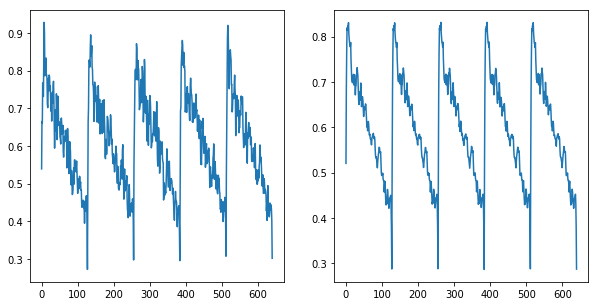

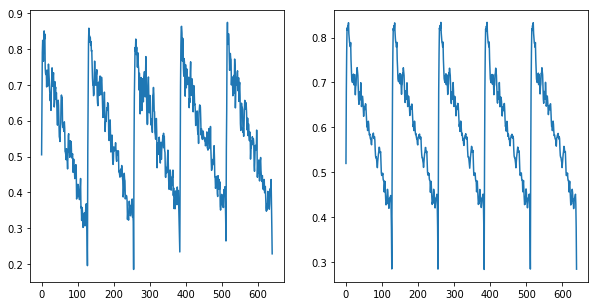

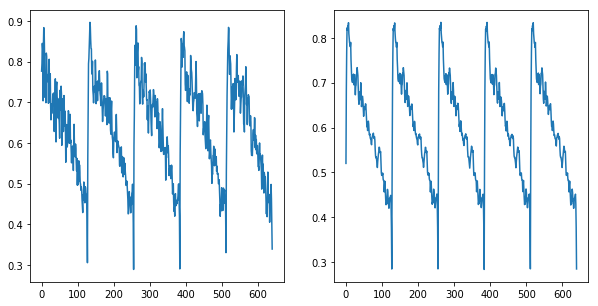

In [4]:
#load_weights(task2.model, 'model/model_ToyCar.pth')
show_some_predictions(task2.train_dataloader(), task2.model, 0, 3)

2020-03-16 10:22:30,843 - INFO - Loading cached __cache_ToyConveyor_val.npy


(1000, 640) (1000, 640)


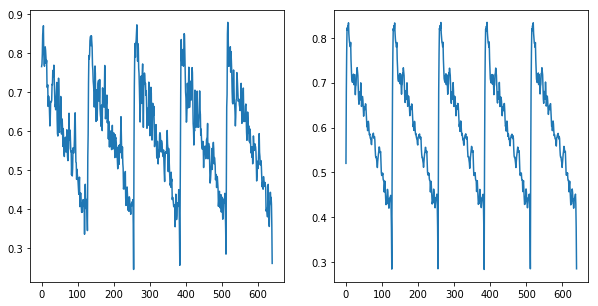

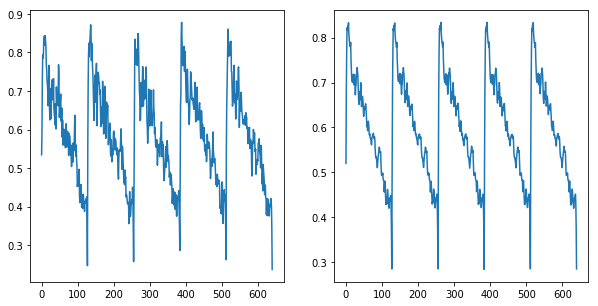

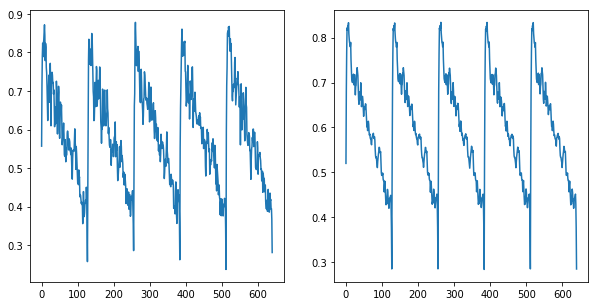

In [5]:
# Validation set samples
show_some_predictions(task2.val_dataloader(), task2.model, 0, 3)

## Check model weights

Weights for bottleneck variables are confirmed to be small.

fc21 is mean weight/bias, and fc22 is variance weight/bias.

In [6]:
summarize_weights(task2.model)

,mean,std,min,max
fc11.weight,-0.003528,0.022959,-0.053914,0.044489
fc11.bias,-0.004042,0.021905,-0.048562,0.039186
fc12.weight,-0.001267,0.029094,-0.146578,0.089692
fc12.bias,-0.009313,0.030355,-0.103346,0.081347
fc21.weight,-0.000992,0.029799,-0.152954,0.154581
fc21.bias,0.002907,0.009339,-0.016254,0.017044
fc22.weight,-0.000665,0.031263,-0.242620,0.138596
fc22.bias,0.000936,0.009083,-0.014675,0.019453
fc31.weight,-0.000175,0.027655,-0.130992,0.121212
fc31.bias,-0.109635,0.234750,-0.425441,0.476140


## It turns out that ... model just learned mean signal...

2020-03-16 10:22:51,266 - INFO - Loading cached __cache_ToyConveyor_train.npy


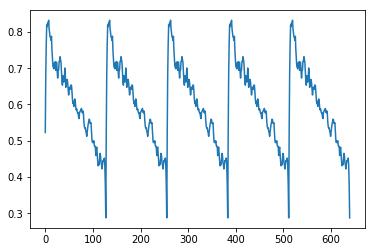

In [9]:
plt.plot(task2.train_dataloader().dataset.X.mean(axis=0))

# Test the trained model

In [7]:
! python 01_test.py -d

2020-03-16 10:22:33,017 - INFO - load_directory <- development

[1/1] /home/dl/lab/task2/dcase2020_task2_variants/dev_data/ToyConveyor
============== MODEL LOAD ==============
2020-03-16 10:22:33,017 - INFO - loading model: ./model/model_ToyConveyor.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         256,400
            Linear-2                  [-1, 400]         160,400
            Linear-3                   [-1, 20]           8,020
            Linear-4                   [-1, 20]           8,020
            Linear-5                  [-1, 400]           8,400
            Linear-6                  [-1, 400]         160,400
            Linear-7                  [-1, 640]         256,640
Total params: 858,280
Trainable params: 858,280
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [8]:
def upto_6digits(cell):
    if not cell[0].isdigit(): return cell
    return f'{float(cell):.6f}'

with open('result/result.csv') as f:
    for l in f.readlines():
        l = l.strip() #replace('\n', '')
        if ',' not in l:
            print(l)
            continue
        ls = l.split(',')
        print(f'{ls[0]}\t\t{upto_6digits(ls[1])}\t\t{upto_6digits(ls[2])}')

ToyConveyor
id		AUC		pAUC
01		0.507269		0.488997
02		0.538644		0.507468
03		0.541677		0.507116
Average		0.529197		0.501194

